## Cloud detection using S2Cloudless
This code is for:
1. Getting cloud mask from S2cloudless model and projected shadow mask using sensor geometry
2. Generate prompts from cloud and shadow mask (removed)
2. Generate SAM output masks using prompts

## Libraries

In [1]:
# import library
import os
import cv2
import time
import math
import glob
import numpy as np
import pandas as pd
from osgeo import gdal
import geopandas as gpd
import xml.etree.ElementTree as ET
from collections import OrderedDict
from shapely.geometry import MultiPolygon, Polygon, box
from s2cloudless import S2PixelCloudDetector, CloudMaskRequest
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
from skimage.morphology import binary_closing, binary_dilation, remove_small_objects, remove_small_holes, square
from skimage.measure import label
import matplotlib.pyplot as plt

/home/ubuntu/anaconda3/envs/s2cloud/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# S2cloudless model pipeline
def convert_4d(data):
    """
    Function : Converting the 3d array to 4d array

    Input : dtype - 3d array 
            Contains - data of 10 bands data ('b01', 'b02', 'b04', 'b05', 'b08', 'b8a', 'b09', 'b10', 'b11', 'b12') 

    Output : dtype - 4d array
             Contains - data of 10 bands data ('b01', 'b02', 'b04', 'b05', 'b08', 'b8a', 'b09', 'b10', 'b11', 'b12') 
    """
    return np.expand_dims(data, 0)


def converting_values(data):
    """
    Function : Converting the reflectance values from 0 to 10000 to the range of 0 to 1

    Input : dtype - dictionary 
            Contains - data of 10 bands data ('b01', 'b02', 'b04', 'b05', 'b08', 'b8a', 'b09', 'b10', 'b11', 'b12') 

    Output : dtype - 3d array
             Contains - Converted range of values from 0 to 1
    """
    all_data = []
#     ['b01'=0, 'b02'=1, 'b04'=3, 'b05'=4, 'b08'=7, 'b8a'=8, 'b09'=9, 'b10'=10, 'b11'=11, 'b12'=12]
    for i in [0, 1, 3, 4, 7, 8, 9, 10, 11, 12]:
        temp_data = np.array(data[:, :, i])/10000
        print(i, np.min(temp_data), np.max(temp_data), np.mean(temp_data))
#         print(temp_data.shape)
        all_data.append(np.array(temp_data))
    return np.dstack(all_data)

def get_cloud_prob(data):
    """
    Function : Generating the cloud probability (Values ranging from 0 to 1 -- 0-not cloudy,1-100% cloudy pixel)

    Input : dtype - 4d array 
            Contains - data of 10 bands data ('b01', 'b02', 'b04', 'b05', 'b08', 'b8a', 'b09', 'b10', 'b11', 'b12') 

    Output : dtype - 3d array
             Contains - Cloud probability array for the input data 
    """
    cloud_detector = S2PixelCloudDetector(threshold=0.4, average_over=4, dilation_size=2)
    bands_10 = converting_values(data)
    print(bands_10.shape)
#     cloud_prob = cloud_detector.get_cloud_probability_maps(bands_10)
    cloud_prob = cloud_detector.get_cloud_masks(bands_10)
    return cloud_prob

In [3]:
# size of an image in a tile
subset_size = 5000

In [5]:
# read example image
_13bands = "./example_data/S2A_MSIL1C_20220101T052231_N0301_R062_T43QEU_20220101T072023.tif"
image_13bands = gdal.Open(_13bands)
# Conver BGR to RGB?
image_array_13bands = image_13bands.ReadAsArray().transpose(1,2,0)
# Select a portion of the image
# image_array_13bands = image_array_13bands[4500:4756, 4500:4756, :]

# Predict tile
start = time.time()
print(image_array_13bands.shape)

cloud_prob = get_cloud_prob(image_array_13bands)
print(cloud_prob.shape)
end = time.time()
print("Predicting time is :", end-start)
# np.unique(cloud_prob)

Warning 1: ./example_data/S2A_MSIL1C_20220101T052231_N0301_R062_T43QEU_20220101T072023.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(10980, 10980, 13)
0 0.0 1.0472 0.18704743318701722
1 0.0 1.188 0.16341079654596422
3 0.0 1.3267 0.14626458620326369
4 0.0 1.2973 0.1573731695083961
7 0.0 1.3419 0.2133951891002354
8 0.0 1.4026 0.2449893898394497
9 0.0 0.4778 0.045952395114814144
10 0.0 0.0145 0.0010877275523306122
11 0.0 1.1232 0.20649905775362404
12 0.0 1.8064 0.13721515479046192
(10980, 10980, 10)
(10980, 10980)
Predicting time is : 954.6268587112427


In [6]:
# S2cloudless output classes
np.unique(cloud_prob, return_counts=True)

(array([0, 1], dtype=int8), array([79284082, 41276318]))

In [7]:
# Changing S2cloudless output to three class
# no_data = 0, non_cloud = 1, cloud =2

cloud_prob2 = cloud_prob + 1
print(np.unique(cloud_prob2))
shp = cloud_prob2.shape
band_2 = image_array_13bands[:, :, 1:2].reshape(shp[0],shp[1])
cloud_mask = np.where(band_2 == 0, 0, cloud_prob2)
print(np.unique(cloud_mask))

[1 2]
[0 1 2]


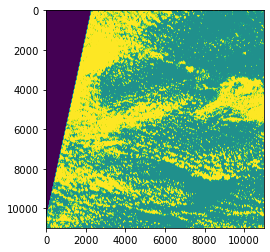

In [8]:
plt.imshow(cloud_mask)
plt.show()

## Shadow projection using Sensor geometry

In [10]:
# green and swir bands
green, swir = image_array_13bands[:,:,2], image_array_13bands[:,:,12]
cloud_mask = cloud_mask.astype('uint8')

# sensor geometry #these values can be obtained using sun_angles function and metadata.xml file
MEAN_SOLAR_AZIMUTH_ANGLE = 151.191991000759
MEAN_SOLAR_ZENITH_ANGLE = 45.0228285174099
# CLOUD_HEIGHT = 1000

In [11]:
start = time.time()
shadow_prj = shadow_projection(MEAN_SOLAR_AZIMUTH_ANGLE, MEAN_SOLAR_ZENITH_ANGLE, 50, 1500, cloud_mask, height_itvl=25)


dark_pxls = dark_pixels(green, swir)
dark_pxls_post = morph_operations(dark_pxls)

# print(np.unique(dark_pxls_post), np.unique(shadow_prj))
# print(dark_pxls_post.dtype, shadow_prj.dtype)

intersection = cv2.bitwise_and(shadow_prj, dark_pxls_post) #shadow
final_mask = cloud_shadow(cloud_mask, intersection) # output
print("Classes in output: ", np.unique(final_mask))

end = time.time()
print("Shadow Projection time: ", end-start)

Solar mean azimuth and solar mean zenith angles in radians: 4.209594372403778, 0.7849997306052967
Final array shape: (10980, 10980)


/home/ubuntu/anaconda3/envs/s2cloud/lib/python3.10/site-packages/skimage/_shared/utils.py:157: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  return func(*args, **kwargs)
/tmp/ipykernel_88639/457395165.py:38: FutureWarning: `selem` is a deprecated argument name for `binary_dilation`. It will be removed in version 1.0. Please use `footprint` instead.
  cloud_bdil = binary_dilation(aclose, selem=st_element)
/tmp/ipykernel_88639/457395165.py:39: FutureWarning: `selem` is a deprecated argument name for `binary_dilation`. It will be removed in version 1.0. Please use `footprint` instead.
  aclose = binary_dilation(cloud_bdil, selem=st_element)
/tmp/ipykernel_88639/457395165.py:42: FutureWarning: in_place argument is deprecated and will be removed in version 1.0. To avoid this warning, please do not use the in_place argument. Please see remove_small_objects documentation for more details. Please use out argument instead.
  cloud_rs

Classes in output:  [0 1 2 3]
Shadow Projection time:  126.96368598937988


In [12]:
# save image
image_array2, image = final_mask, image_13bands #change input array here
t_rows, t_cols = image_array2.shape
outfile = './sample_tile.tif'
outdriver = gdal.GetDriverByName("GTiff")

outdata = outdriver.Create(outfile, t_cols, t_rows, 1, gdal.GDT_Byte)
outdata.GetRasterBand(1).WriteArray(image_array2)

proj = image.GetProjection()
trans = image.GetGeoTransform()
outdata.SetProjection(proj)
outdata.SetGeoTransform(trans)
del outdata

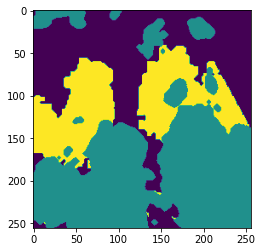

In [17]:
# 0: no_data, 1: clear_pixels, 2:cloud, 3: shadow (clear_pixels = no_cloud & no_shadow)

# visualise small subset (subset from another subset)
plt.imshow(final_mask)
plt.show()

## Generating prompts & final segmentation mask with SAM

In [97]:
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

### Center pixel as a prompt to SAM

In [98]:
def find_segment_center(binary_image):
    # Convert the binary image to a numpy array
    binary_array = np.array(binary_image)
    
    # Find the indices of the non-zero pixels (segment)
    indices = np.nonzero(binary_array)

    # Calculate the center coordinates
    center_x = np.mean(indices[1])
    center_y = np.mean(indices[0])

    return [int(center_x), int(center_y)]

def select_random_points(binary# Run sklearn algorithms using all cores
from sklearnex import patch_sklearn
patch_sklearn()_image, num_points):
    # Convert the binary image to a numpy array
    binary_array = np.array(binary_image)

    # Find the indices of the non-zero pixels (segment)
    indices = np.argwhere(binary_array != 0)

    # Randomly select num_points indices
    random_indices = np.random.choice(len(indices), size=num_points, replace=False)

    # Get the random point locations within the segment
    random_points = indices[random_indices]
    random_points = np.flip(random_points, axis=1)
    
    return random_points.tolist()

def prompt_points_for_image(input_arr, num_points=None, area_threshold = 50, center_point=False):
    if center_point:
        cmps = label(input_arr)
        pts = []
        for i in np.unique(cmps):
            img_ = np.where(cmps==i, 1, 0)
            if np.sum(img_) > area_threshold:
                cetere_lo = find_segment_center(img_)
                pts.append(cetere_lo)
    else:
        pts = select_random_points(input_arr, num_points)
    return np.array(pts)

In [104]:
final_cloud_mask = np.where(final_mask==2, 1, 0)
final_shadow_mask = np.where(final_mask==3, 1, 0)
cloud_and_shadow = np.where(final_mask>1, 1, 0)
back_gound_mask = np.where(final_mask==1, 1, 0)

In [105]:
shadow_prompts = prompt_points_for_image(final_shadow_mask, num_points=50)
cloud_prompts = prompt_points_for_image(final_cloud_mask, num_points=50)
cloud_and_shadow_prompts = prompt_points_for_image(cloud_and_shadow, num_points=50)
backgournd_prompts = prompt_points_for_image(back_gound_mask, num_points=50)

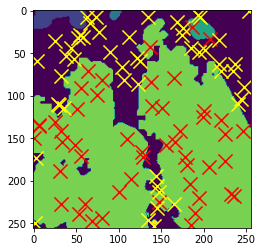

In [112]:
# Shadow mask and prompts
plt.imshow(label(cloud_and_shadow))
plt.scatter(cloud_and_shadow_prompts[:, 0], cloud_and_shadow_prompts[:, 1], marker="x", color="red", s=200)
plt.scatter(backgournd_prompts[:, 0], backgournd_prompts[:, 1], marker="x", color="yellow", s=200)
plt.show()

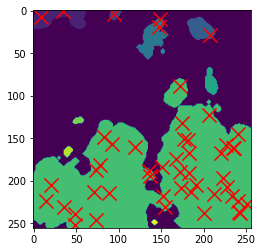

In [113]:
# Shadow mask and prompts
plt.imshow(label(final_cloud_mask))
plt.scatter(cloud_prompts[:, 0], cloud_prompts[:, 1], marker="x", color="red", s=200)
plt.show()

(256, 256, 3)


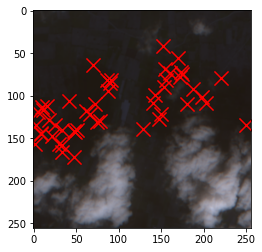

In [85]:
# visualise rgb image and shadow prompts
rgb_img = image_array_13bands[:, :, 1:4]/10000  # [4500:4756, 4500:4756, :]
rgb_img = np.where(rgb_img>1, 1, rgb_img)*255
rgb_img = rgb_img.astype('uint8')
print(rgb_img.shape)
plt.imshow(rgb_img)
plt.scatter(shadow_prompts[:, 0], shadow_prompts[:, 1], marker="x", color="red", s=200)
plt.show()

(256, 256, 3)


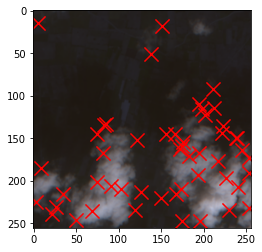

In [86]:
# Cloud prompts
print(rgb_img.shape)
plt.imshow(rgb_img_.astype('uint8'))
plt.scatter(cloud_prompts[:, 0], cloud_prompts[:, 1], marker="x", color="red", s=200)
plt.show()

In [119]:
print(rgb_img.shape)
predictor.set_image(rgb_img)

(256, 256, 3)


In [121]:
# all prompts (combination of bothe cloud and shadow)
all_prompts = np.concatenate((cloud_and_shadow_prompts, backgournd_prompts), axis=0)
# print(all_prompts)

backgorund_label = np.zeros((backgournd_prompts.shape[0],))
foreground_label = np.ones(cloud_and_shadow_prompts.shape[0])
all_labels = np.concatenate((foreground_label, backgorund_label), axis=0)

# Select promps
input_point = all_prompts  # shadow_prompts cloud_prompts
input_label = all_labels

In [122]:
rgb_img.shape

(256, 256, 3)

In [123]:
from PIL import Image
im = Image.fromarray(rgb_img)
im.save("./cropped_rgb_cloud_tile.jpeg")

In [124]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

In [125]:
masks.shape

(3, 256, 256)

In [126]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

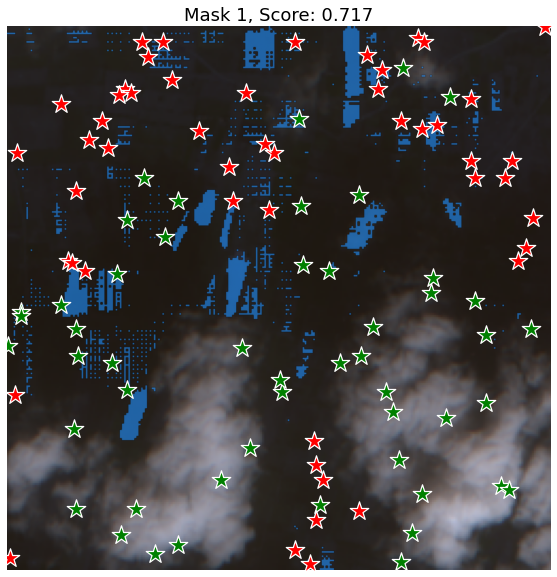

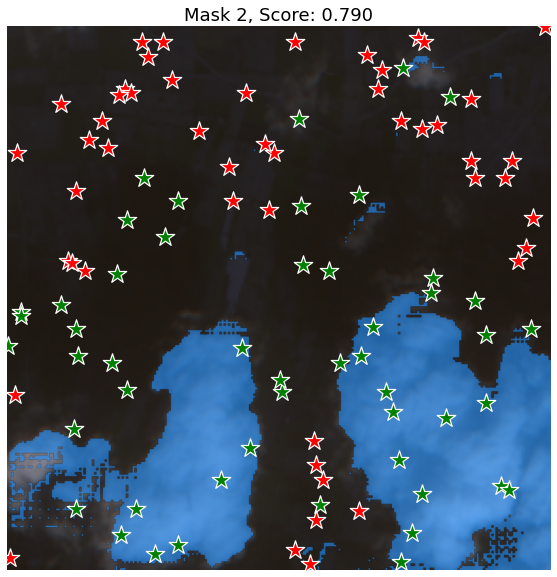

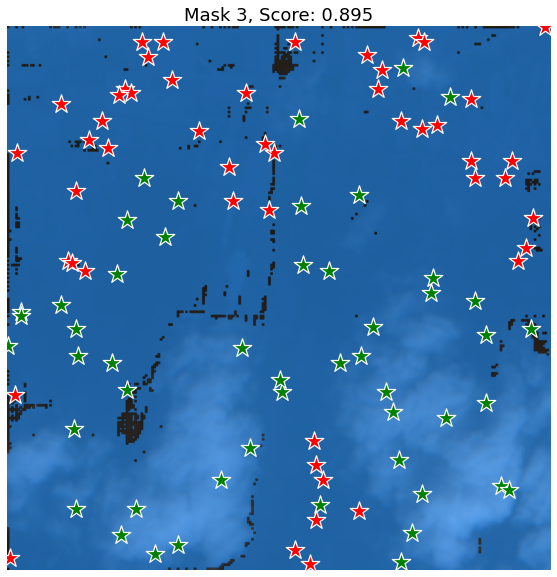

In [127]:
image = rgb_img_.astype('uint8')
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()

### BBOX as a prompt to SAM

### Mask as a prompt to SAM

In [50]:
test = np.expand_dims(final_cloud_mask2, axis=0)
test.shape

(1, 256, 256)

In [51]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input = test,
    multimask_output=True,
)

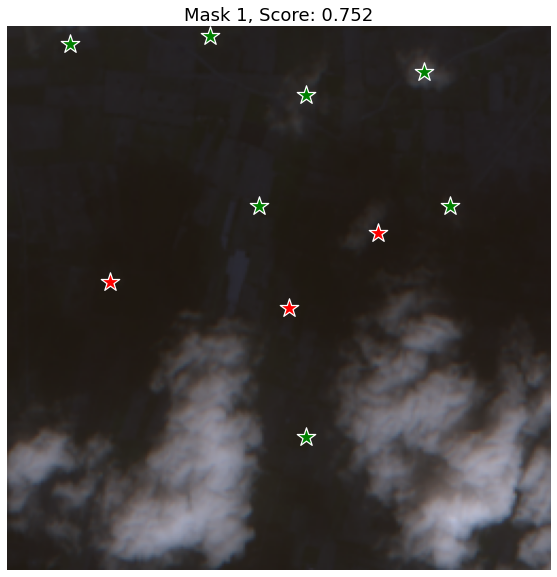

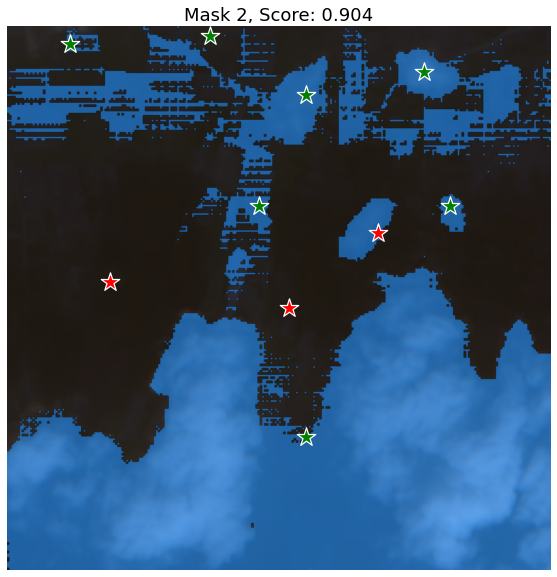

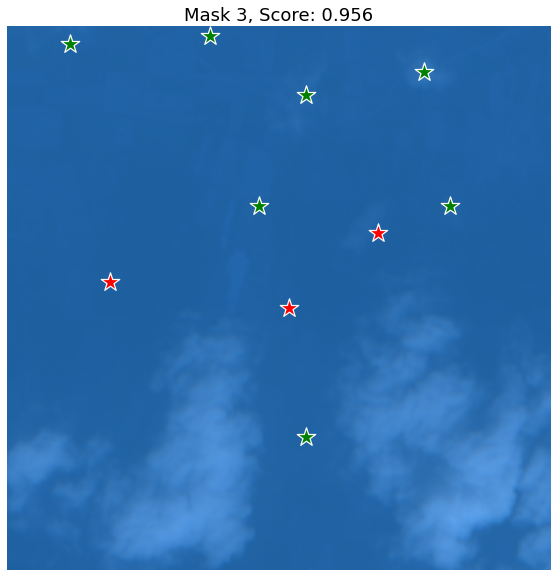

In [52]:
image = rgb_img_.astype('uint8')
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()